# Tools

In [65]:
import pandas as pd
import datetime as dt
import numpy as np
import missingno as msno  # 視覺化觀察是否有 missing value
pd.options.display.max_columns=None

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# ML
from sklearn.ensemble import RandomForestRegressor

# Evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression

# Load data

> **Data Fields**
>- datetime 
    - hourly date + timestamp  
>- season
    1. spring
    2. summer
    3. fall
    4. winter 
>- holiday 
    - whether the day is considered a holiday
        0. 非假日
        1. 假日
>- workingday 
    - whether the day is neither a weekend nor holiday
        0. 非工作日
        1. 工作日
>- weather 
    1. Clear, Few clouds, Partly cloudy, Partly cloudy
    2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
>- temp 
    - temperature in Celsius
>- atemp 
    - "feels like" temperature in Celsius（體感溫度？）
>- humidity 
    - relative humidity
>- windspeed 
    - wind speed
>- casual（非註冊用戶） 
    - number of non-registered user rentals initiated
>- registered（註冊用戶） 
    - number of registered user rentals initiated
>- count（總租借輛數） 
    - number of total rentals
    - count = casual + registered

In [14]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sampleSubmission = pd.read_csv('sampleSubmission.csv')

train_df = train.copy()
test_df = test.copy()

In [15]:
print(train.shape[0])
train.head()

10886


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [16]:
print(test.shape[0])
test.head()

6493


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [17]:
sampleSubmission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


# Data preprocessing

## Data types

In [18]:
display(train_df.head())
train_df.dtypes

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [19]:
train_df.datetime = pd.to_datetime(train_df.datetime, format='%Y-%m-%d %H:%M:%S')
test_df.datetime = pd.to_datetime(test_df.datetime, format='%Y-%m-%d %H:%M:%S')

## Missing value

- 沒有缺失值。
- 需再注意資料是否有誤 or 不合理。

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


<AxesSubplot:>

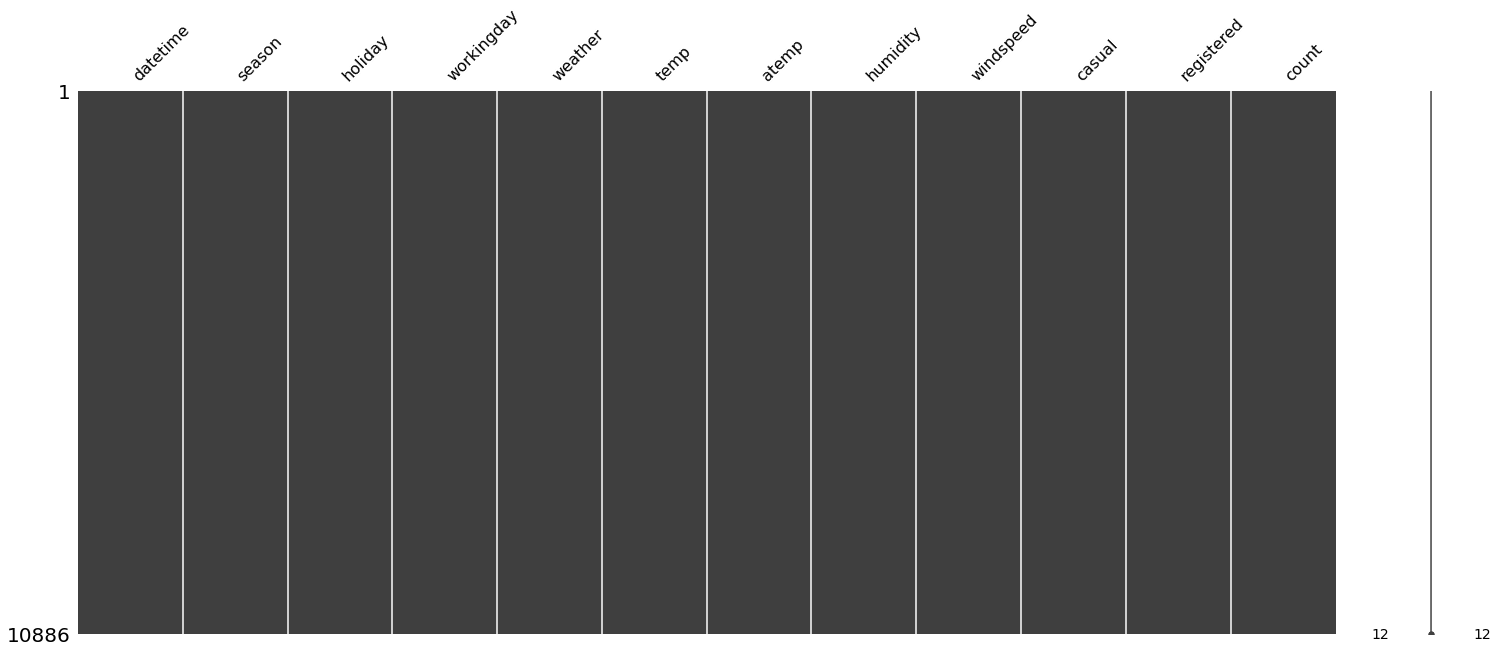

In [21]:
msno.matrix(train_df)

## Feature Engineering

- model 沒辦法直接吃 datetime 格式的資料，所以需要進行拆分。
- datetime
    - date
    - year
    - month
    - weekday（星期幾）
    - hour

In [22]:
def col_datetime_transform(df):
    df['date'] = df.datetime.apply(lambda x : x.date())
    df['year'] = df.datetime.apply(lambda x : x.year)
    df['month'] = df.datetime.apply(lambda x : x.month)
    df['weekday'] = df.datetime.apply(lambda x : x.isoweekday())
    df['hour'] = df.datetime.apply(lambda x : x.hour)
    return df

In [23]:
train_df = col_datetime_transform(train_df)
test_df = col_datetime_transform(test_df)

In [24]:
train_df.dtypes
test_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
date                  object
year                   int64
month                  int64
weekday                int64
hour                   int64
dtype: object

# EDA

1. 欄位檢視
2. Count 與各變數交叉分析
    - Count v.s Time
        - month
        - weekday
        - hour
    - Count v.s Season
    - Count v.s Holiday
    - Count v.s Workingday
    - Count v.s Temp
    - Count v.s Atemp
    - Count v.s Humidity
    - Count v.s Windspeed
    - Correlation matrix

## 欄位檢視

### casual / registered / count

- count = casual + registered
    - 75% = 284
    - count > 600 : 412 筆
- 看起來 count 有 outlier。
- 後面跑模型可以比較有無去除 outlier 的差別。

In [25]:
train_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,4.013963,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,2.004585,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,2.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,4.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,6.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,7.000000,23.000000


Text(0.5, 0, 'count')

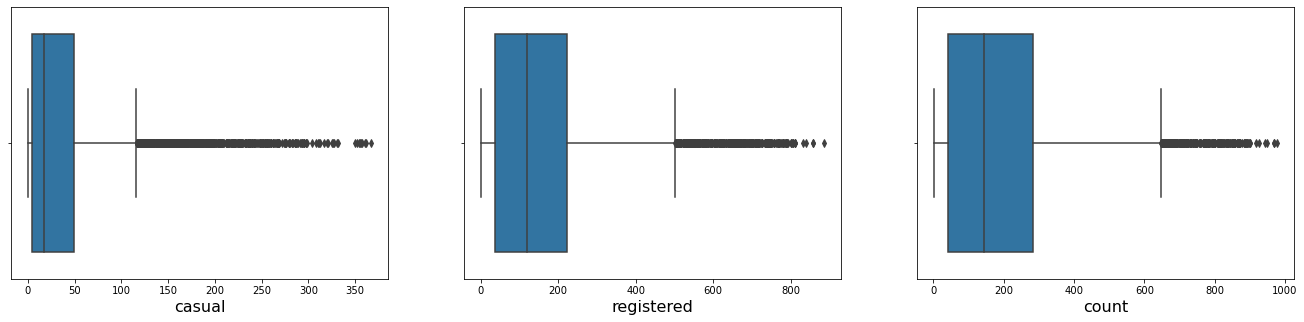

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(23,5))
# fig.set_size_inches(23,5)

sns.boxplot(data=train_df, x='casual', ax=axes[0])
sns.boxplot(data=train_df, x='registered', ax=axes[1])
sns.boxplot(data=train_df, x='count', ax=axes[2])

axes[0].set_xlabel('casual', fontsize=16)
axes[1].set_xlabel('registered', fontsize=16)
axes[2].set_xlabel('count', fontsize=16)

In [27]:
train_df.query('count > 600').shape[0]

412

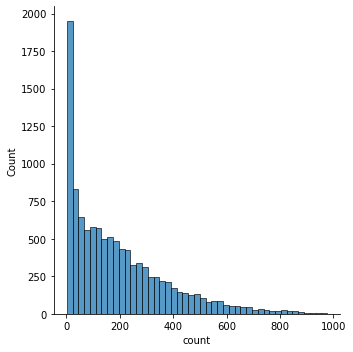

In [28]:
# fig, axes = plt.subplots(ncols=3,nrows=1)
# fig
# axes[0]

# sns.displot(train_df.casual, ax=axes[0])
# sns.displot(train_df.registered, ax=axes[1])
# sns.displot(train_df['count'], ax=axes[2])

# sns.displot(train_df.casual)
# sns.displot(train_df.registered)
sns.displot(train_df['count'])

### 其他欄位

- weather
    - 1 > 2 > 3 >> 4
- windspeed
    - 資料呈現不連續的狀況，且風速為 0 的資料頗多 **--> 推測資料有問題，需進行處理**

In [29]:
display(train_df.season.value_counts())
display(train_df.holiday.value_counts())
display(train_df.workingday.value_counts())
train_df.weather.value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

0    10575
1      311
Name: holiday, dtype: int64

1    7412
0    3474
Name: workingday, dtype: int64

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

<AxesSubplot:xlabel='windspeed', ylabel='Count'>

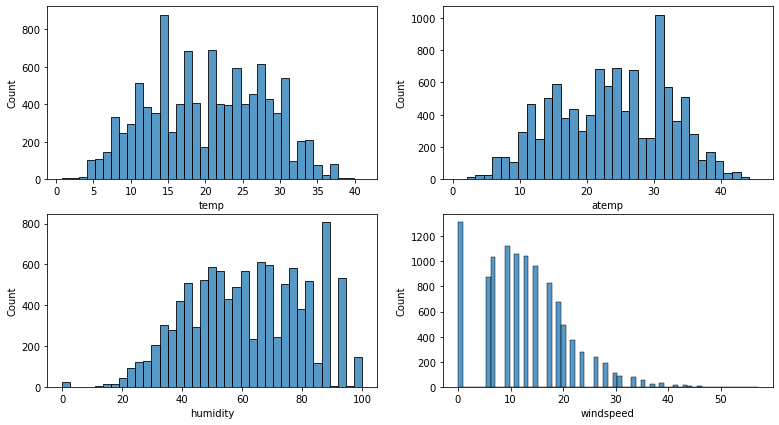

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,7))

sns.histplot(data=train_df, x='temp', ax=axes[0][0])
sns.histplot(data=train_df, x='atemp', ax=axes[0][1])
sns.histplot(data=train_df, x='humidity', ax=axes[1][0])
sns.histplot(data=train_df, x='windspeed', ax=axes[1][1])

# sns.distplot(train_df['temp'], ax=axes[0][0])
# sns.distplot(train_df['atemp'], ax=axes[0][1])
# sns.distplot(train_df['humidity'], ax=axes[1][0])
# sns.distplot(train_df['windspeed'], ax=axes[1][1])

# sns.kdeplot(train_df['temp'], ax=axes[0][0])
# sns.kdeplot(train_df['atemp'], ax=axes[0][1])
# sns.kdeplot(train_df['humidity'], ax=axes[1][0])
# sns.kdeplot(train_df['windspeed'], ax=axes[1][1])

#### Windspeed 處理

- 以風速不為0的資料，去預測風速為0的資料的真正風速應為多少。
1. 先合併 train data & test data，將資料分成風速為0以及風速不為0的資料。
2. 並且用風速不為0的資料來訓練random forest的模型
3. 將訓練好的模型來預估風速為0的風速到底是多少。

In [31]:
# 先合併 train data & test data，將資料分成風速為0以及風速不為0的資料

combine_df = pd.concat([train_df, test_df]).reset_index(drop=True)
wind0_df = combine_df.query('windspeed == 0')
windNot0_df = combine_df.query('windspeed != 0')

windNot0_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,weekday,hour
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.0,1.0,1.0,2011-01-01,2011,1,6,5
10,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12.0,24.0,36.0,2011-01-01,2011,1,6,10
11,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26.0,30.0,56.0,2011-01-01,2011,1,6,11
12,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29.0,55.0,84.0,2011-01-01,2011,1,6,12
13,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47.0,47.0,94.0,2011-01-01,2011,1,6,13


In [32]:
# 用風速不為0的資料來訓練random forest的模型
"""
    - n_estimators: 1000棵樹
    - random_state: 隨機性設定。數字一樣，跑出來的結果會一樣（like用一樣的方式洗牌）
"""

model = RandomForestRegressor(n_estimators=1000, random_state=42)

# Fit model
"""
    Q: 如何挑選訓練模型的 feature？
    Q: 預測結果的評分衡量？
"""
train_cols = ['season', 'weather', 'temp', 'atemp', 'humidity', 'year', 'month']  # 用於訓練模型的 feature
train_x = windNot0_df[train_cols]
train_y = windNot0_df['windspeed']
model.fit(train_x, train_y)

# Get predict result
predict_x = wind0_df[train_cols]
predict_y = model.predict(predict_x)
predict_y

array([ 6.90649702,  6.78156882,  6.78156882, ...,  7.37120969,
       25.98090356,  6.92396308])

In [33]:
# 將訓練好的結果合併回df

wind0_df['windspeed'] = predict_y
afterPredict_df = pd.concat([wind0_df, windNot0_df])

# 拆分 training set & testing set
newTrain_df = afterPredict_df[afterPredict_df['count'].notnull()]
newTest_df = afterPredict_df[afterPredict_df['count'].isnull()]

<ipython-input-33-cd6d339234fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind0_df['windspeed'] = predict_y


In [34]:
newTrain_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
date                  object
year                   int64
month                  int64
weekday                int64
hour                   int64
dtype: object

>**預測前後比較**

Text(0.5, 1.0, 'After prediction')

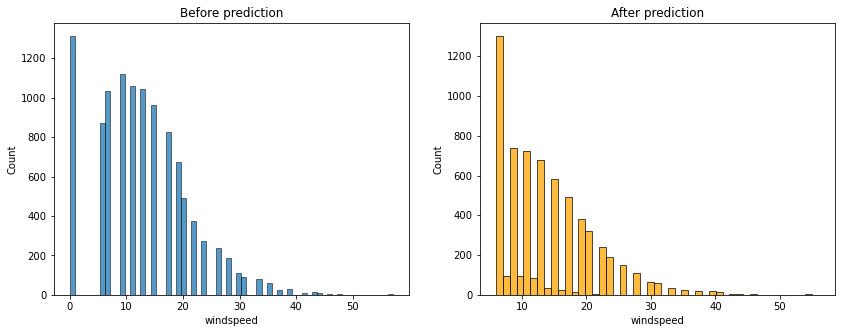

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

sns.histplot(data=train_df, x='windspeed', ax=axes[0])
sns.histplot(data=newTest_df, x='windspeed', ax=axes[1], 
             color='orange')

axes[0].set_title('Before prediction')
axes[1].set_title('After prediction')

## 租借數量與各變數交叉分析

- Count v.s Time
    - month
    - weekday
    - hour
- Count v.s Season
- Count v.s Holiday
- Count v.s Workingday
- Count v.s Temp
- Count v.s Atemp
- Count v.s Humidity
- Count v.s Windspeed
- Correlation matrix

In [36]:
newTrain_df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual               float64
registered           float64
count                float64
date                  object
year                   int64
month                  int64
weekday                int64
hour                   int64
dtype: object

In [37]:
newTrain_df.season = newTrain_df.season.map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
newTrain_df.head(3)

/Users/maxyeh/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,weekday,hour
0,2011-01-01 00:00:00,Spring,0,0,1,9.84,14.395,81,6.906497,3.0,13.0,16.0,2011-01-01,2011,1,6,0
1,2011-01-01 01:00:00,Spring,0,0,1,9.02,13.635,80,6.781569,8.0,32.0,40.0,2011-01-01,2011,1,6,1
2,2011-01-01 02:00:00,Spring,0,0,1,9.02,13.635,80,6.781569,5.0,27.0,32.0,2011-01-01,2011,1,6,2


### Time

- Hour：
    - 在 7:00 ~ 9:00、17:00 ~ 19:00 的租借數量普遍高於其他時段。
    - 但以上現象僅限於平日，可以發現假日的逐時曲線與平日不同。
    - 平日的高峰時段，推測可能是因為介於上下班、上下學時段的原因。

In [38]:
newTrain_df.groupby('weekday').agg({'count':'sum'}).reset_index()

,weekday,count
0,1,295296.0
1,2,291985.0
2,3,292226.0
3,4,306401.0
4,5,302504.0
5,6,311518.0
6,7,285546.0


Text(0, 0.5, '')

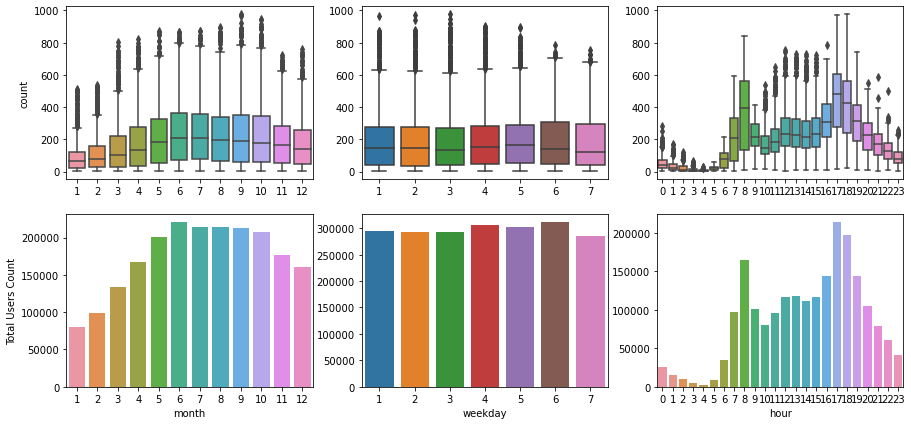

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,7))

sns.boxplot(data=newTrain_df, x='month', y='count', ax=axes[0][0])
sns.boxplot(data=newTrain_df, x='weekday', y='count', ax=axes[0][1])
sns.boxplot(data=newTrain_df, x='hour', y='count', ax=axes[0][2])

sns.barplot(data=newTrain_df.groupby('month').agg({'count':'sum'}).reset_index(), 
            x='month', y='count', ax=axes[1][0])
sns.barplot(data=newTrain_df.groupby('weekday').agg({'count':'sum'}).reset_index(), 
            x='weekday', y='count', ax=axes[1][1])
sns.barplot(data=newTrain_df.groupby('hour').agg({'count':'sum'}).reset_index(), 
            x='hour', y='count', ax=axes[1][2])

axes[0][0].set_xlabel('')
axes[0][1].set_xlabel('')
axes[0][2].set_xlabel('')
axes[0][1].set_ylabel('')
axes[0][2].set_ylabel('')
axes[1][0].set_ylabel('Total Users Count')
axes[1][1].set_ylabel('')
axes[1][2].set_ylabel('')

Text(0, 0.5, 'Avg. Count')

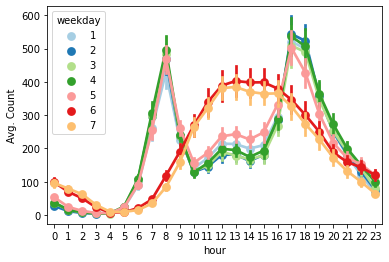

In [40]:
sns.pointplot(data=newTrain_df, x='hour', y='count', hue='weekday', palette="Paired")
plt.ylabel('Avg. Count')

### Season / Holiday / Workingday

- Season：春季的租借數量相較其他季節低。
- Holiday / Workingday：可以看到多數的 Outlier 出現在工作日。

<AxesSubplot:xlabel='workingday', ylabel='count'>

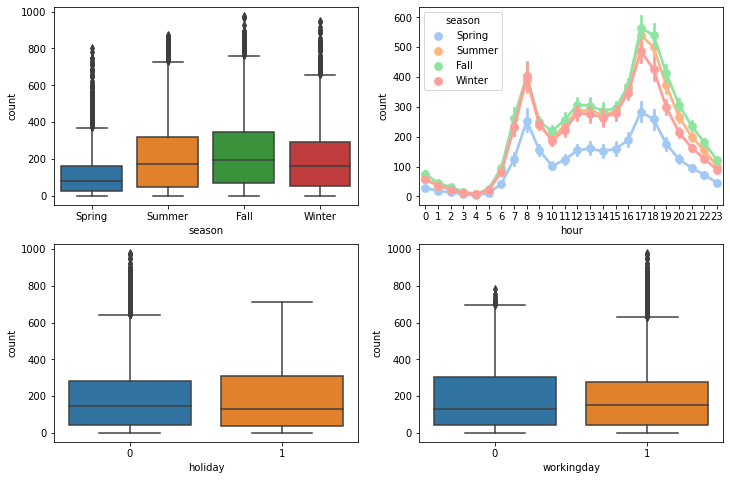

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

sns.boxplot(data=newTrain_df, x='season', y='count', ax=axes[0][0])
sns.pointplot(data=newTrain_df, x='hour', y='count', hue='season', palette="pastel", ax=axes[0][1])
sns.boxplot(data=newTrain_df, x='holiday', y='count', ax=axes[1][0])
sns.boxplot(data=newTrain_df, x='workingday', y='count', ax=axes[1][1])

### Temp / Atemp / Humidity / Windspeed

- Temp & Atemp 具有高度正相關。
- 租借數量分別與溫度、濕度呈現正、負相關，但相關性不高。

<AxesSubplot:xlabel='windspeed', ylabel='count'>

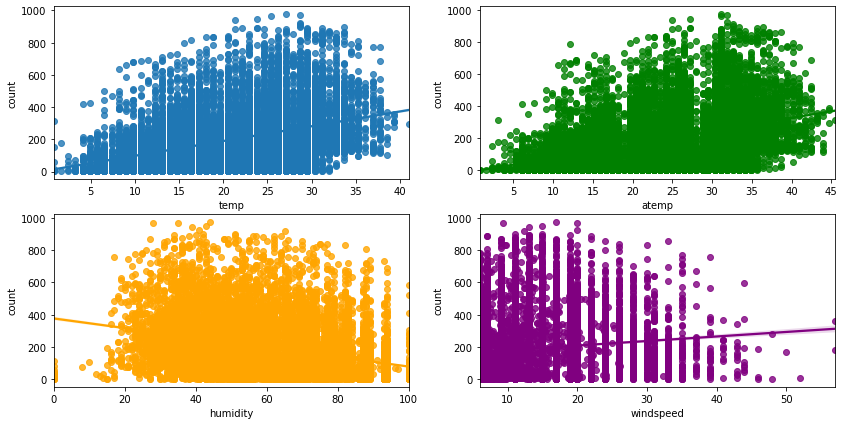

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,7))

sns.regplot(data=newTrain_df, x='temp', y='count', ax=axes[0][0])
sns.regplot(data=newTrain_df, x='atemp', y='count', ax=axes[0][1], color='g')
sns.regplot(data=newTrain_df, x='humidity', y='count', ax=axes[1][0], color='orange')
sns.regplot(data=newTrain_df, x='windspeed', y='count', ax=axes[1][1], color='purple')

<AxesSubplot:>

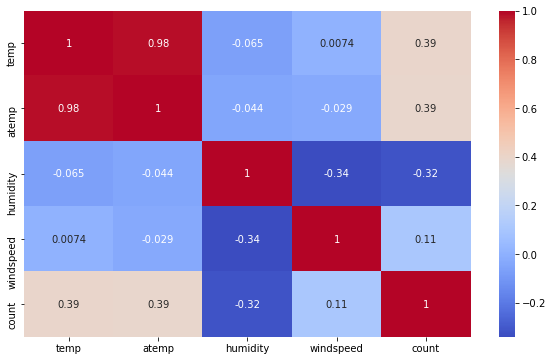

In [43]:
corr_df = newTrain_df.loc[:, ['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')

# Models

## 前置作業

### count 分佈觀察

- 透過取 log 讓 count 更接近常態分佈一些。

/Users/maxyeh/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/maxyeh/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

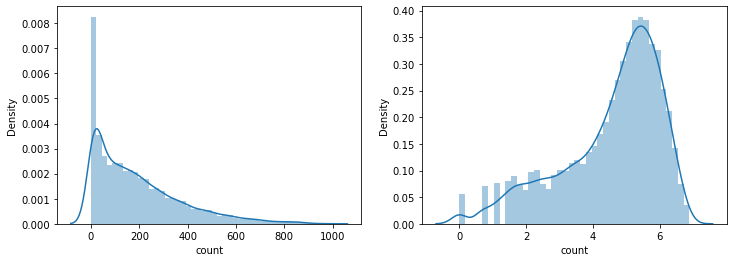

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.distplot(newTrain_df['count'], ax=axes[0])
sns.distplot(np.log(newTrain_df['count']), ax=axes[1])

### 欄位調整

In [45]:
newTrain_df.columns
drop_features = ['datetime', 'casual', 'registered','date']

model_train = newTrain_df.drop(columns=drop_features)
model_train.season = model_train.season.map({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})
model_test = newTest_df.drop(columns=drop_features)

## Evaluation

In [1]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Random Forest

### V1

In [47]:
model_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,weekday,hour
10887,1,0,1,1,10.66,13.635,56,8.779129,NaN,2011,1,4,1
10888,1,0,1,1,10.66,13.635,56,8.779129,NaN,2011,1,4,2
10898,1,0,1,2,12.30,16.665,42,6.982447,NaN,2011,1,4,12
10946,1,0,0,1,3.28,8.335,35,8.392651,NaN,2011,1,6,13
10948,1,0,0,1,4.92,7.575,28,12.216704,NaN,2011,1,6,15


In [57]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)

train_x = model_train.drop(columns='count')
train_y = np.log(model_train['count'])
predict_x = model_test.drop(columns='count')

rfModel.fit(train_x, train_y)
predictTrain_y = rfModel.predict(train_x)
predictTest_y = rfModel.predict(predict_x)

In [58]:
rmsle(train_y, predictTrain_y)

0.10703856994287891

In [59]:
submit_df = pd.DataFrame({'datetime': newTest_df.datetime.values, 'count': np.exp(predictTest_y)})
submit_df

,datetime,count
0,2011-01-20 01:00:00,4.794911
1,2011-01-20 02:00:00,2.770479
2,2011-01-20 12:00:00,76.565987
3,2011-01-22 13:00:00,61.655405
4,2011-01-22 15:00:00,62.392483
...,...,...
6488,2012-12-31 19:00:00,283.572965
6489,2012-12-31 20:00:00,199.803764
6490,2012-12-31 21:00:00,137.612458
6491,2012-12-31 22:00:00,109.467215


In [60]:
submit_df.to_csv('Submission_bikeSharingDemand_RF1.csv', index=False)

### V2

- 拿掉 atemp 欄位

In [61]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)

train_x = model_train.drop(columns=['count', 'atemp'])
train_y = np.log(model_train['count'])
predict_x = model_test.drop(columns=['count', 'atemp'])

rfModel.fit(train_x, train_y)
predictTrain_y = rfModel.predict(train_x)
predictTest_y = rfModel.predict(predict_x)

In [62]:
rmsle(train_y, predictTrain_y)

0.10668157305670298

In [67]:
np.sqrt(mean_squared_log_error(np.exp(train_y), np.exp(predictTrain_y)))

0.10668157305670298

In [63]:
submit_df = pd.DataFrame({'datetime': newTest_df.datetime.values, 'count': np.exp(predictTest_y)})
submit_df

,datetime,count
0,2011-01-20 01:00:00,4.546528
1,2011-01-20 02:00:00,2.654887
2,2011-01-20 12:00:00,73.245377
3,2011-01-22 13:00:00,54.021803
4,2011-01-22 15:00:00,61.718859
...,...,...
6488,2012-12-31 19:00:00,288.059849
6489,2012-12-31 20:00:00,201.257628
6490,2012-12-31 21:00:00,148.072369
6491,2012-12-31 22:00:00,108.486338


In [64]:
submit_df.to_csv('Submission_bikeSharingDemand_RF2.csv', index=False)

### V3

- 拿掉 atemp 欄位
- 排除 count outlier

In [86]:
model_train[np.abs(model_train['count']-model_train['count'].mean()) <= 3*std]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,weekday,hour
0,1,0,0,1,9.84,14.395,81,6.906497,16.0,2011,1,6,0
1,1,0,0,1,9.02,13.635,80,6.781569,40.0,2011,1,6,1
2,1,0,0,1,9.02,13.635,80,6.781569,32.0,2011,1,6,2
3,1,0,0,1,9.84,14.395,75,6.700497,13.0,2011,1,6,3
4,1,0,0,1,9.84,14.395,75,6.700497,1.0,2011,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.002700,336.0,2012,12,3,19
10882,4,0,1,1,14.76,17.425,57,15.001300,241.0,2012,12,3,20
10883,4,0,1,1,13.94,15.910,61,15.001300,168.0,2012,12,3,21
10884,4,0,1,1,13.94,17.425,61,6.003200,129.0,2012,12,3,22


In [87]:
rfModel = RandomForestRegressor(n_estimators=1000, random_state=42)

train_x = model_train[np.abs(model_train['count']-model_train['count'].mean()) <= 3*std
                     ].drop(columns=['count', 'atemp'])
train_y = np.log(model_train[np.abs(model_train['count']-model_train['count'].mean()) <= 3*std]['count'])
predict_x = model_test.drop(columns=['count', 'atemp'])

rfModel.fit(train_x, train_y)
predictTrain_y = rfModel.predict(train_x)
predictTest_y = rfModel.predict(predict_x)

In [88]:
rmsle(train_y, predictTrain_y)

0.10737319075944221

In [89]:
submit_df = pd.DataFrame({'datetime': newTest_df.datetime.values, 'count': np.exp(predictTest_y)})
submit_df

,datetime,count
0,2011-01-20 01:00:00,4.616682
1,2011-01-20 02:00:00,2.643042
2,2011-01-20 12:00:00,74.006944
3,2011-01-22 13:00:00,54.178993
4,2011-01-22 15:00:00,59.111661
...,...,...
6488,2012-12-31 19:00:00,289.466044
6489,2012-12-31 20:00:00,198.273949
6490,2012-12-31 21:00:00,146.232012
6491,2012-12-31 22:00:00,107.517179


In [90]:
submit_df.to_csv('Submission_bikeSharingDemand_RF3.csv', index=False)